# Ray start/stop

In [ ]:
ray.init(ignore_reinit_error=True)

In [ ]:
import ray
ray.shutdown()

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("bokeh_output.html")
# import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# import pdb; pdb.set_trace()
# import pudb; pudb.set_trace()

# .describe(include='all', datetime_is_numeric=True)
# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")
# .plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height", xlim=[0, .1])

# filter/batch trades

In [35]:
from data_model import s3_backend
from bar_sampler import meta
# get raw ticks
tdf1 = s3_backend.fetch_date_df('VTI', '2020-01-02', tick_type='trades')

VTI 2020-01-02 trying to get data from local file...


In [36]:
# filter ticks
tdf2 = meta.filter_trades(tdf1)

False   0.995907
True    0.004093
Name: mad_outlier, dtype: float64


In [54]:
# enrich ticks
tdf3 = meta.enrich_tick(tdf2)

In [61]:
tdf3.status.value_counts()

clean                             30468
filtered: irregular conditions      145
filtered: MAD outlier               126
filtered: ts diff                    44
filtered: zero volume                 1
Name: status, dtype: int64

In [ ]:
# tdf.set_index('nyc_dt').price.plot()

# tdf[['price', 'price_jma']].plot_bokeh(sizing_mode="scale_height")

# bdf.volume.plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height")

tdf[tdf.mad_outlier==False].set_index('nyc_dt').price.plot()

# (tdf.nyc_dt.shift(-20) - tdf.nyc_dt).describe(percentiles=[.8, .9, .99, .995])

# Sample tick dates

In [66]:
thresh = {
    # meta params
    'symbol': 'VTI',
    'start_date': '2020-01-09',
    'end_date': '2020-01-12',
    # filter
    'mad_value_winlen': 22,
    'mad_deviation_winlen': 1111,
    'mad_k': 11,
    'jma_winlen': 7,
    'jma_power': 2,
    # time batcher
    'batch_freq': '3s',
    # bar sampler params
    'renko_return': 'price_jma_return',
    'renko_size': 0.1,
    'renko_reveral_multiple': 2,
    'renko_range_frac': 22,
    'max_duration_td': dt.timedelta(minutes=33),
    'min_duration_td': dt.timedelta(seconds=33),
    'min_tick_count': 33,
    # label params
    'add_label': True,
    'reward_ratios': list(np.arange(2, 11, 0.5)),
}

In [5]:
from bar_sampler.meta import get_bar_date, get_bar_dates

bd = get_bar_date(thresh, date='2020-01-02')
# bds = get_bar_dates(thresh)

VTI 2020-01-02 trying to get data from local file...
False   0.998945
True    0.001055
Name: mad_outlier, dtype: float64


100%|██████████| 7760/7760 [00:26<00:00, 289.70it/s]


In [7]:
from utilities.pickle import pickle_dump, pickle_load

# bds = pickle_load('/data_tmp/bds_v2.plk')

# bds = pickle_dump('/data_tmp/bds_v2.plk')

35
neutral   0.714286
profit    0.285714
Name: label_outcome, dtype: float64


<AxesSubplot:>

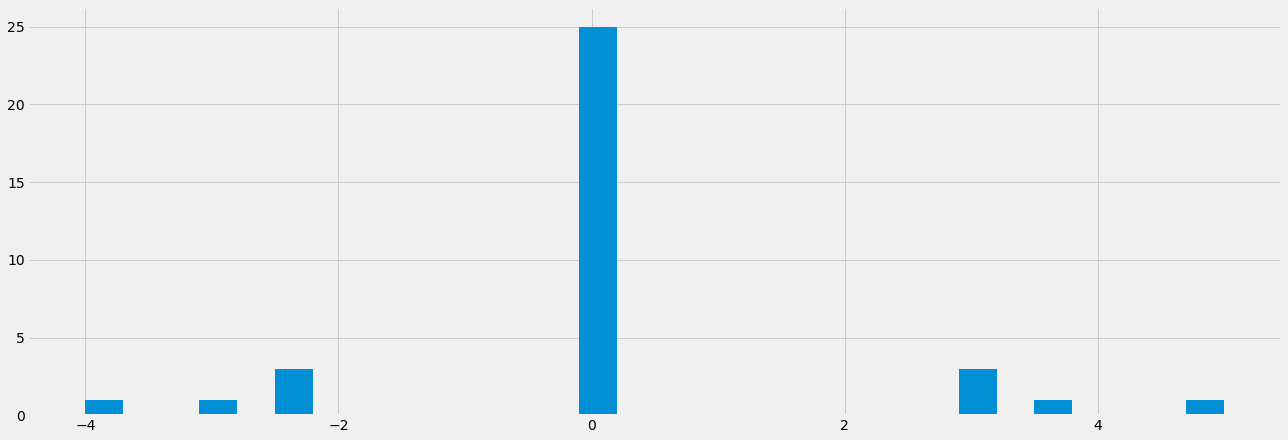

In [111]:
bars_df = bds[5]['bars_df']
print(len(bars_df))
print(bars_df.label_outcome.value_counts()/len(bars_df))
bars_df.label_rrr.hist(bins=30)

In [ ]:
bars_df[['price_high','price_low', 'price_vwap']].plot_bokeh(sizing_mode="scale_height")

In [114]:
from bar_sampler.stacked import fill_gaps_dates, stacked_df_stats

In [107]:
# fill daily gaps
stacked_df = fill_gaps_dates(bds, fill_col='price_vwap')

stacked_df[['price_high','price_low','price_vwap']].plot_bokeh(sizing_mode="scale_height")

Figure(id='3352', ...)

In [118]:
# stacked stats
stats_df = stacked_df_stats(stacked_df)
stats_df.describe()

,bar_count,duration_min_median,price_range_mean
count,6.000000,6.000000,6.000000
mean,35.333333,7.070833,0.162252
std,10.366613,2.330258,0.011726
min,25.000000,4.600000,0.147699
25%,28.250000,5.031250,0.154042
50%,32.000000,6.950000,0.163475
75%,41.000000,8.737500,0.166543
max,52.000000,10.200000,0.180400


In [119]:
stats_df

,date,bar_count,duration_min_median,price_range_mean,first_bar_open,last_bar_close
0,2020-01-03,52,4.725000,0.166801,2020-01-03 09:31:03-05:00,2020-01-03 15:51:51-05:00
1,2020-01-06,25,10.200000,0.165768,2020-01-06 09:31:03-05:00,2020-01-06 15:53:27-05:00
2,2020-01-07,29,9.000000,0.161181,2020-01-07 09:31:03-05:00,2020-01-07 15:53:00-05:00
3,2020-01-08,43,4.600000,0.180400,2020-01-08 09:31:03-05:00,2020-01-08 15:56:54-05:00
4,2020-01-09,28,7.950000,0.151663,2020-01-09 09:31:03-05:00,2020-01-09 15:55:45-05:00
5,2020-01-10,35,5.950000,0.147699,2020-01-10 09:31:03-05:00,2020-01-10 15:54:00-05:00


In [ ]:
results = []

for date in bar_dates:
    out = (date['ticks_df'].status.value_counts() / date['ticks_df'].shape[0]).to_dict()
    out.update({'date': date['date']})
    results.append(out)

pd.DataFrame(results)